In [1]:
from __future__ import annotations

In [2]:
from config.dl_model_config import DLModelConfig
from ipsqt.prediction.dl.dl_predictor import DLPredictor

from ipsqt.strategies.predicted.binary_position_strategy import BinaryPositionStrategy
from ipsqt.prediction.dl.models.mlp import MLP
from run import initialize

In [3]:
REBAL_FREQ = "D"
STRATEGY = BinaryPositionStrategy
MODEL = MLP
RETRAIN = False

SAVE = True

In [4]:
preprocessor, runner = initialize()

predictor = DLPredictor(
    model_cls=MODEL,
    model_config=DLModelConfig(),
    n_features=len(runner.available_features),
    verbose=False,
)

strategy = STRATEGY(
    predictor=predictor,
    retrain=RETRAIN,
)

strategy_name = strategy.__class__.__name__
model_name = predictor.model.__class__.__name__

Backtest on 2013-03-24 00:00:00 to 2024-05-05 00:00:00
Num Train Iterations: 581
Num OOS Daily Points: 581


In [5]:
result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)

Computing Weights: 100%|██████████| 581/581 [00:01<00:00, 329.16it/s]


In [6]:
result

StrategyStatistics:
* final_nav = 3.780051
* geom_avg_total_r = 0.126384
* geom_avg_xs_r = 0.112750
* std_xs_r = 0.163739
* min_xs_r = -0.149641
* max_xs_r = 0.126046
* skew = -0.587038
* kurtosis = 7.149714
* max_dd = -0.324589
* sharpe = 0.688600
* alpha_buy_hold = -0.015227
* tracking_error_buy_hold = 0.002454
* ir_buy_hold = -6.204784
* factor_loadings = {'_MKT': 0.9998641478883646}
* alpha_benchmark = -0.015210
* alpha_benchmark_pvalue = 0.000000
* tracking_error_benchmark = 0.002454
* ir_benchmark = -6.198393
* ttest_pval = 0.577031
* levene_pval = 0.995809
* timing_ability_coef = -0.001288
* timing_ability_pval = 0.458758

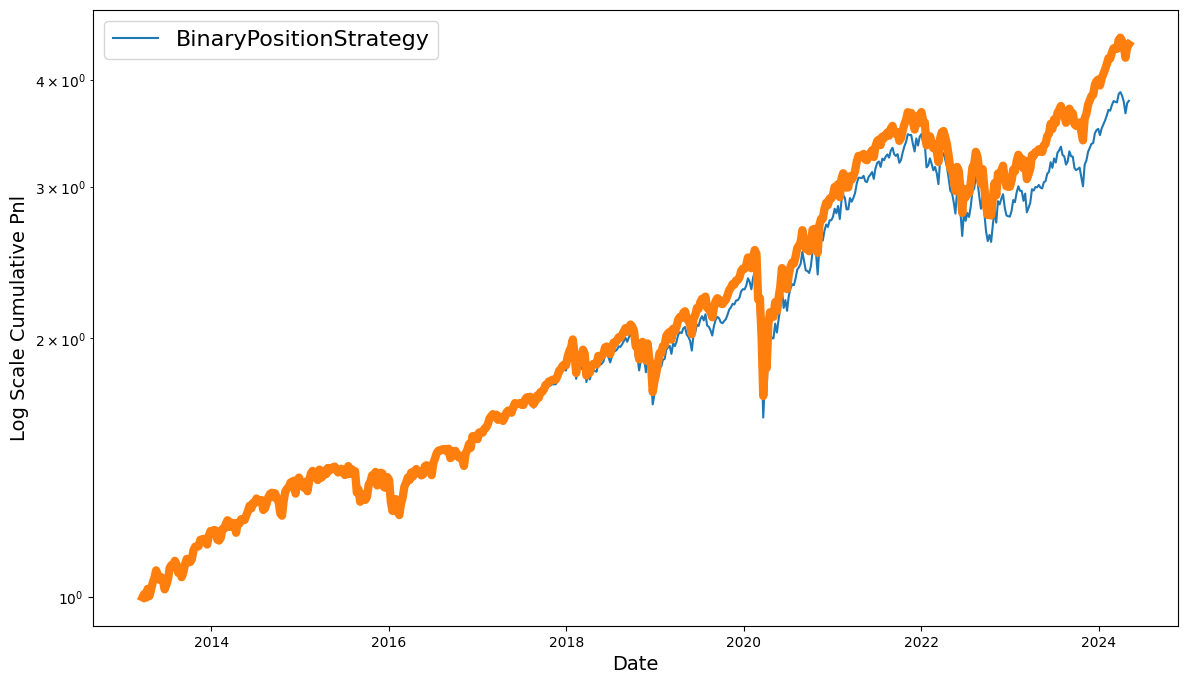

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

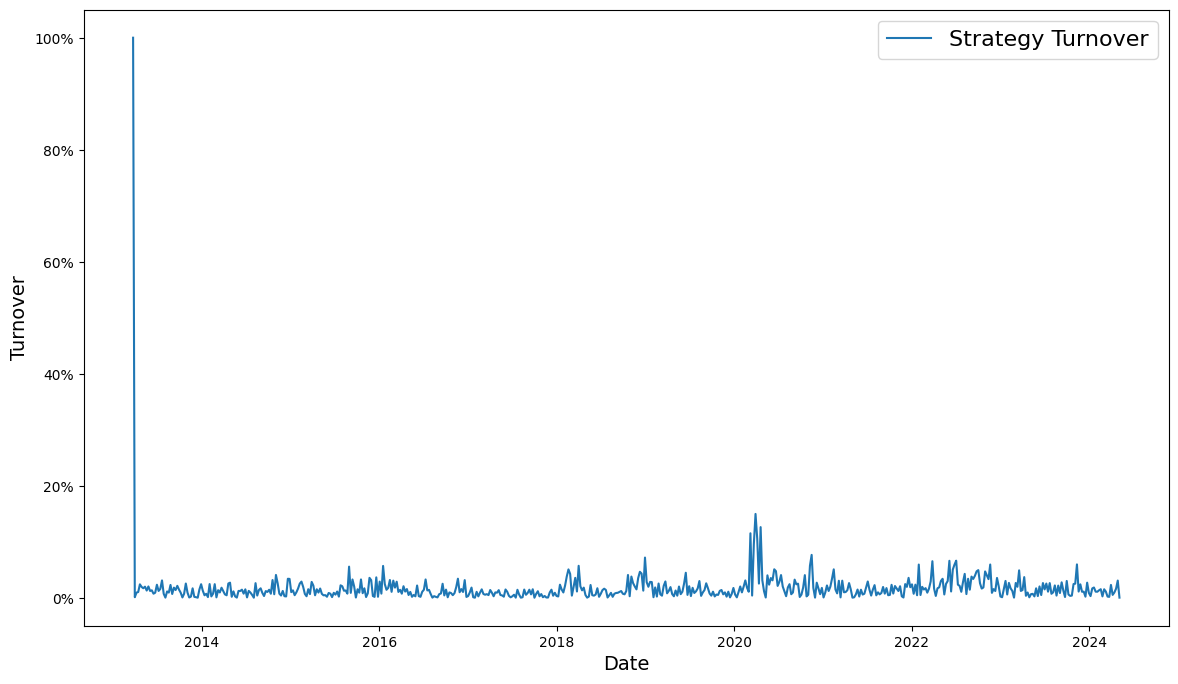

In [8]:
runner.plot_turnover()

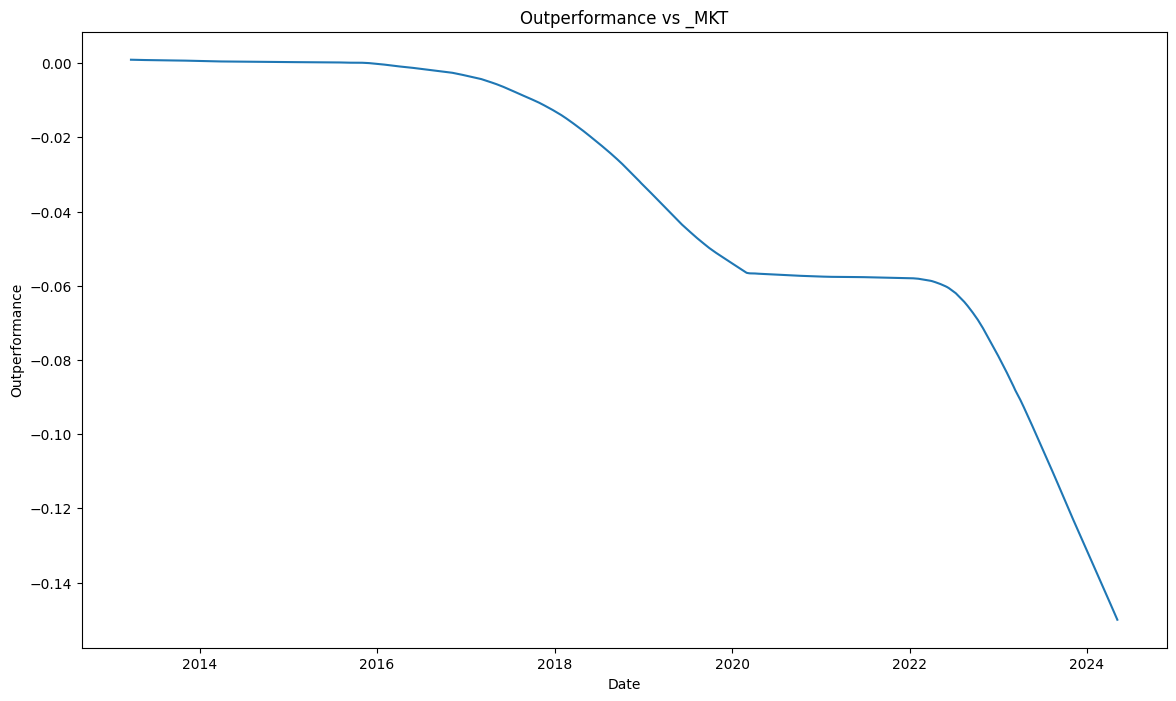

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
if SAVE:
    runner.save(f"{strategy_name}_" + model_name + f"_rebal{REBAL_FREQ}")